In [3]:
import numpy as np

np.arange(5)

array([0, 1, 2, 3, 4])

In [16]:
# encode type

n_types = 5
t = 1
board = np.array([[-1, -1, -1], [-1, 1, -1], [-1, 1, 1]])

print("board")
print(board)
print("type")
print(t)

enc_types = np.zeros(n_types, dtype=bool)
enc_types[t] = 1

enc_board = (board==1).flatten()
print("enc_board")
print(enc_board)

print("enc_types")
print(enc_types)

occ = np.hstack((enc_board, enc_types))
print("occ")
print(occ)

pow = 1<<np.arange(occ.size)
print("pow")
print(pow)

code = pow@occ
print("code")
print(code)


def encode_state(n_tiles, board, tile_type):
    enc_types = np.zeros(n_tiles, dtype=bool)
    enc_types[tile_type] = 1
    enc_board = (board==1).flatten()

    occ = np.hstack((enc_board, enc_types))
    pow = 1 << np.arange(occ.size)
    code = pow@occ

    return code


print("func output")
encode_state(n_types, board, t)



board
[[-1 -1 -1]
 [-1  1 -1]
 [-1  1  1]]
type
1
enc_board
[False False False False  True False False  True  True]
enc_types
[False  True False False False]
occ
[False False False False  True False False  True  True False  True False
 False False]
pow
[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
code
1424
func output


1424

In [17]:
n_pos = 10
n_ori = 4

tile_positions = np.arange(n_pos)
tile_orientations = np.arange(n_ori)

tile_positions = np.repeat(np.arange(n_pos, dtype=int), n_ori)
tile_orientations = np.tile(np.arange(n_ori, dtype=int), n_pos)
actions = np.vstack((tile_positions, tile_orientations)).T
actions

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3],
       [7, 0],
       [7, 1],
       [7, 2],
       [7, 3],
       [8, 0],
       [8, 1],
       [8, 2],
       [8, 3],
       [9, 0],
       [9, 1],
       [9, 2],
       [9, 3]])

In [18]:
import gmpy2

int(gmpy2.pack([1 for _ in range(65)], 1))

36893488147419103231

In [63]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SmallStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 2, padding=0),
            nn.ReLU(),
            nn.Flatten(1),   # dim 
            nn.Linear(512, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.Tanh(),
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 512),
            nn.ReLU(),
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(32, 16, 1, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 1, stride=1, padding=0),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [64]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 4, 4))
data = torch.Tensor(data)


In [65]:
ae_small = SmallStateAutoEncoder(8, 64).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae_small.parameters(), lr=3E-4)
load_small_encoder = False
save_small_encoder = True

losses = []
run_loss = 0
n_epochs = 200

if load_small_encoder:
    ae_small.load_state_dict(torch.load('./src/models/ae_small.pt'))

ae_small.train()
for epoch in range(n_epochs):

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae_small(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}/{n_epochs}')
        print(f'loss: {train_loss}')


if save_small_encoder:
    ae_small.eval()
    torch.save(
        ae_small.state_dict(), './src/models/ae_small.pt'
    )

epoch: 0/200
loss: 0.8519814112223685
epoch: 10/200
loss: 0.18799929379019886
epoch: 20/200
loss: 0.04045357204449829
epoch: 30/200
loss: 0.01399930182742537
epoch: 40/200
loss: 0.006650894822996634
epoch: 50/200
loss: 0.0053713639358647924
epoch: 60/200
loss: 0.00527185009900677
epoch: 70/200
loss: 0.006756335907084576
epoch: 80/200
loss: 0.005721700042386146
epoch: 90/200
loss: 0.005379584496495227
epoch: 100/200
loss: 0.004526027329930571
epoch: 110/200
loss: 0.004898565706923819
epoch: 120/200
loss: 0.004155496065173736
epoch: 130/200
loss: 0.0039705527162832155
epoch: 140/200
loss: 0.003969157675708157
epoch: 150/200
loss: 0.003968452596586625
epoch: 160/200
loss: 0.003967978348355938
epoch: 170/200
loss: 0.0028900360965460337
epoch: 180/200
loss: 0.002886047831279104
epoch: 190/200
loss: 0.00288515030357539


[[ 0.2883302   0.47906125  0.21276057 -0.01157598  0.13971364  0.56654614
   0.4223579   0.04958561]]


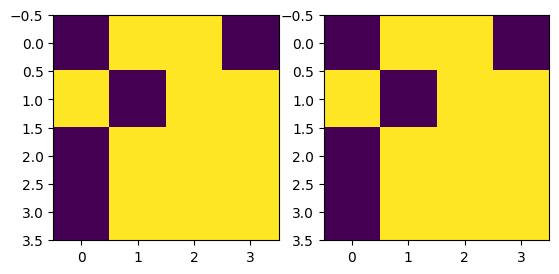

In [66]:
import matplotlib.pyplot as plt

ex_grid = np.array([[-1, 1, 1, -1], [1, -1, 1, 1], [-1, 1, 1, 1], [-1, 1, 1, 1]])
ex_grid = ex_grid.reshape(1, 1, 4, 4)
ex_grid = torch.Tensor(ex_grid).to(device)

ae_small.eval()
ex_y = torch.sgn(ae_small(ex_grid))
print(ae_small.encoder(ex_grid).detach().cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid.detach().cpu().numpy().squeeze())
ax2.imshow(ex_y.detach().cpu().numpy().squeeze())

In [156]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LargeStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 6, padding=1),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(2048, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.Tanh()
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [157]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 8, 8))
data = torch.Tensor(data)


In [162]:
ae_large = LargeStateAutoEncoder(32, 512).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae_large.parameters(), lr=3E-4)
load_large_encoder = False
save_large_encoder = True

losses = []
run_loss = 0
n_epochs = 150

if load_large_encoder:
    ae_large.load_state_dict(torch.load('./src/models/ae_large.pt'))

ae_large.train()
for epoch in range(n_epochs):

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae_large(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}/{n_epochs}')
        print(f'loss: {train_loss}')


if save_large_encoder:
    ae_large.eval()
    torch.save(
        ae_large.state_dict(), './src/models/ae_large.pt'
    )

epoch: 0/150
loss: 0.9746197061613202
epoch: 10/150
loss: 0.3672874493058771
epoch: 20/150
loss: 0.21226572943851352
epoch: 30/150
loss: 0.16558124625589699
epoch: 40/150
loss: 0.13614280114416033
epoch: 50/150
loss: 0.10699690051842481
epoch: 60/150
loss: 0.08461793855531141
epoch: 70/150
loss: 0.07578418240882456
epoch: 80/150
loss: 0.06055967099382542
epoch: 90/150
loss: 0.052510737732518464
epoch: 100/150
loss: 0.04254707501968369
epoch: 110/150
loss: 0.03568383511446882
epoch: 120/150
loss: 0.029464754363289103
epoch: 130/150
loss: 0.026083590637426823
epoch: 140/150
loss: 0.024714456005312968


torch.Size([128, 1, 8, 8])


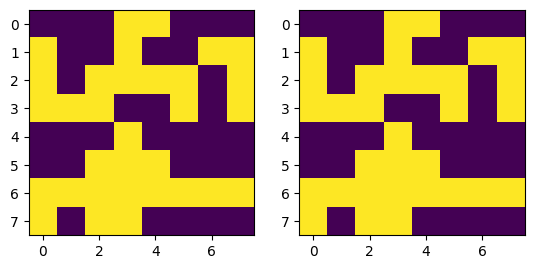

In [163]:
import matplotlib.pyplot as plt

ex_grid = data[0]
ex_grid = torch.Tensor(ex_grid).to(device)
print(ex_grid.shape)

ae_large.eval()
ex_y = torch.sgn(ae_large(ex_grid))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid[0].detach().cpu().numpy().squeeze())
ax2.imshow(ex_y[0].detach().cpu().numpy().squeeze())

In [ ]:
import numpy as np

action = (1, 2)

a = np.arange(10).reshape(5, 2)

for action in a:
    print(tuple(action))

(0, 1)
(2, 3)
(4, 5)
(6, 7)
(8, 9)


In [12]:
import torch

a = torch.randint(0, 50, (5, 5, 2))
a[[1, 2, 3]].shape

torch.Size([3, 5, 2])